## Denne kladdeboken er ment for å dokumentere optimaliseringen av bredbånd parametere.
- Christoffer Aaseth 07.04.2025

Parameterene for bredbånd er `window_size` og `hilbert_win`.

- `window_size` -  angir lengden (i sekunder) på det tidsvinduet som brukes for en ny glatting av signalet etter nedsampling, for å fjerne gjenværende støy. Det påvirker størrelsen på glattevinduet i det nye (nedsamplede) signalet, og dermed hvor mye signalet smøres ut i tid.

- `hilbert_win` - bestemmer antall samples brukt til glatting (moving average) av det kvadrerte Hilbert-envelope-signalet og brukes også som nedsamplingsfaktor. Et høyere tall gir mer glatting og lavere tidsoppløsning (mindre detaljert over tid), men mindre støy.

Begge parametere styrer altså graden av tidsmessig glatting og filtrering i signalbehandlingen, men på forskjellige nivåer:
`hilbert_win` før og under nedsampling, og `window_size` etterpå.


De beste parameterverdiene bestemmes ut i fra hvilken kombinasjon av verdier som gir best `SNR` for bredbåndanalysen. 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from time import perf_counter

import sys
import os

# Get the current notebook directory
notebook_dir = os.getcwd()  # Should be my_project/my_notebooks

# Go one level up (to my_project/)
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))

# Path to the folder containing your module
module_dir = os.path.join(project_root, 'Processing_scripts')

# Add it to sys.path if it's not already there
if module_dir not in sys.path:
    sys.path.append(module_dir)

# Now import the module
import functions



#--------------------------------------------------------------------------------------------------
#Color generator
import colorsys

def generate_vivid_colors(x):
    """
    Generate x vivid and distinct RGB colors using evenly spaced hues in HSV.
    
    Args:
        x (int): Number of colors
    
    Returns:
        List of RGB tuples (r, g, b) with values in [0, 1]
    """
    colors = []
    for i in range(x):
        hue = i / x
        rgb = colorsys.hsv_to_rgb(hue, 1.0, 1.0)  # Full saturation & brightness
        colors.append(rgb)
    return colors
#--------------------------------------------------------------------------------------------------


# NB!
Metoden under fungerer, men er veldig treg for mange iterasjoner. Bruk heller `Broadband_opt_script.py` for å generere SNR data og last over datasettet via en csv fil.

Calculation time with window_size = 2 and Hilbert_win = 5 t = 2.78[s]
Calculation time with window_size = 2 and Hilbert_win = 10 t = 0.85[s]
Calculation time with window_size = 2 and Hilbert_win = 15 t = 0.60[s]
Calculation time with window_size = 2 and Hilbert_win = 20 t = 0.48[s]
Calculation time with window_size = 2 and Hilbert_win = 25 t = 0.46[s]
Calculation time with window_size = 4 and Hilbert_win = 5 t = 4.32[s]
Calculation time with window_size = 4 and Hilbert_win = 10 t = 1.31[s]
Calculation time with window_size = 4 and Hilbert_win = 15 t = 0.77[s]
Calculation time with window_size = 4 and Hilbert_win = 20 t = 0.59[s]
Calculation time with window_size = 4 and Hilbert_win = 25 t = 0.49[s]
Calculation time with window_size = 6 and Hilbert_win = 5 t = 6.36[s]
Calculation time with window_size = 6 and Hilbert_win = 10 t = 1.83[s]
Calculation time with window_size = 6 and Hilbert_win = 15 t = 1.02[s]
Calculation time with window_size = 6 and Hilbert_win = 20 t = 0.71[s]
Calculati

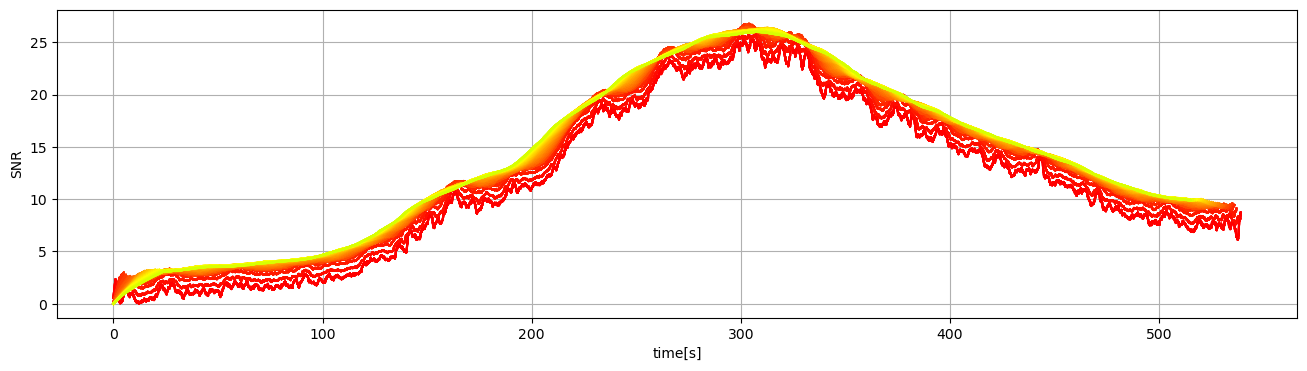

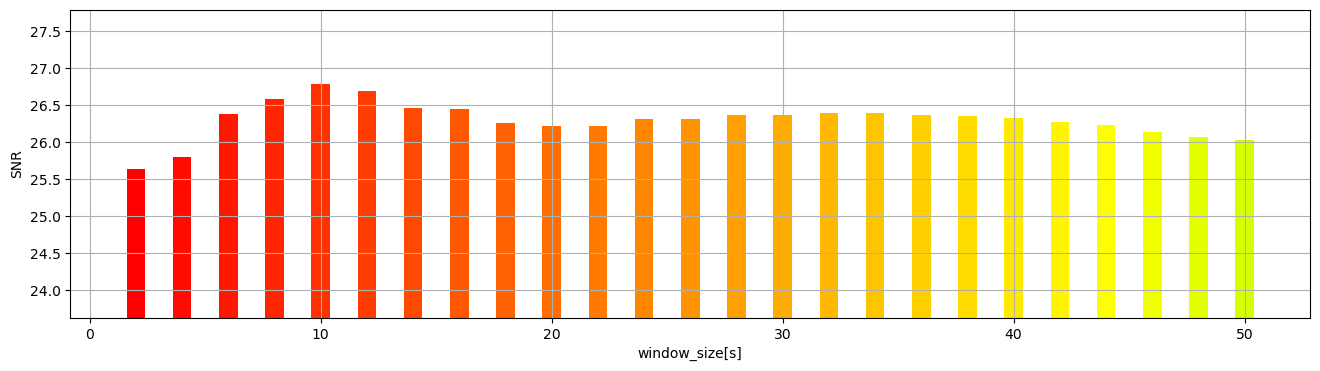

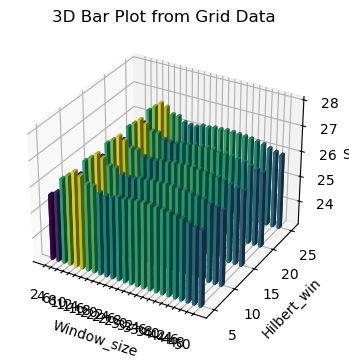


------------------------------
Best SNR : 26.786904955719145
window_size : 0
hilbert_win : 8
------------------------------


In [44]:

Audio_path = "/Users/christofferaaseth/Documents/GitHub/hydrophonic-detection/Sound_data/001029.wav"

fs = 10_000
hilbert_win = 5
window_size = 2
num_window_iterations = 25
num_hilbert_iterations = 5

colors = generate_vivid_colors(num_window_iterations*num_hilbert_iterations)

sx, fs = functions.load_audiofile(Audio_path, fs, fc_low=5)


Max_SNR = np.zeros((num_hilbert_iterations,num_window_iterations)) #Row[i] hilbert_win , col[j] window_size
bar_window_ax = np.linspace(window_size,window_size*num_window_iterations,num_window_iterations)
bar_hilb_ax = np.linspace(hilbert_win,hilbert_win*num_hilbert_iterations,num_hilbert_iterations)

fig = plt.figure(figsize=(16,4))
for i in range(1,num_window_iterations+1):

    for j in range(1,num_hilbert_iterations+1):
        #Generating data
        sx_buff = []
        BB_t0 = perf_counter()
        BB, BB_t, sx_buff = functions.BB_data(sx,fs,sx_buff, hilbert_win*j, window_size*i)
        BB = BB - BB.min()
        BB_t1 = perf_counter()
        print(f"Calculation time with window_size = {window_size*i} and Hilbert_win = {hilbert_win*j} t = {(BB_t1-BB_t0):.2f}[s]")
        


        #Saving max SNR for every hilbert iteration
        Max_SNR[j-1][i-1] = BB.max()

        plt.plot(BB_t,BB,color=colors[i-1])
        plt.xlabel("time[s]")
        plt.ylabel("SNR")
        plt.grid()


histogram = plt.figure(figsize=(16,4))
plt.bar(bar_window_ax,Max_SNR[0],color=colors)
plt.xlabel("window_size[s]")
plt.ylabel("SNR")
plt.ylim((np.min(Max_SNR)-2,np.max(Max_SNR)+1))
plt.grid()

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm



# Make a meshgrid of x/y positions
x_pos, y_pos = np.meshgrid(bar_window_ax, bar_hilb_ax, indexing='xy')



# Flatten the grid for bar3d
x_pos = x_pos.ravel()
y_pos = y_pos.ravel()

dz = Max_SNR.ravel()                      # Heights of bars
zlim_min = dz.min()*0.9
zlim_max = np.max(Max_SNR)*1.05
dz_scaled = dz - zlim_min
z_pos = np.full_like(x_pos, zlim_min)        # Bars start at z = zlim_min

# Bar size
dx = dy = 0.8

# Normalize dz to 0–1 for colormap
norm_dz = (dz - dz.min()) / (dz.max() - dz.min())
# Color (optional: based on height)
colors3d = cm.viridis(norm_dz)

# Plot
fig3d = plt.figure(figsize=(16,4))
ax = fig3d.add_subplot(111, projection='3d')

ax.bar3d(x_pos-dx/2, y_pos-dy/2, z_pos, dx, dy, dz_scaled, color=colors3d, shade=True)

ax.set_xlabel('Window_size')
ax.set_ylabel('Hilbert_win')
ax.set_zlabel('SNR')
ax.set_title('3D Bar Plot from Grid Data')
ax.set_zlim(zlim_min,zlim_max)

ax.set_xticks(np.unique(x_pos))
ax.set_yticks(np.unique(y_pos))

plt.show()


# Get the index of the max value
max_index = np.unravel_index(np.argmax(Max_SNR), Max_SNR.shape)
print("")
print("------------------------------")
print(f"Best SNR : {Max_SNR.max()}")
print(f"window_size : {max_index[0]*hilbert_win}")
print(f"hilbert_win : {max_index[1]*window_size}")
print("------------------------------")


# Visualiser og drøft data fra `Broadband_opt_script.py`



/var/folders/zg/23sg06wj2kzb1l0qdkk5tr140000gn/T/ipykernel_21400/3422382755.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = db.groupby("plot_id")


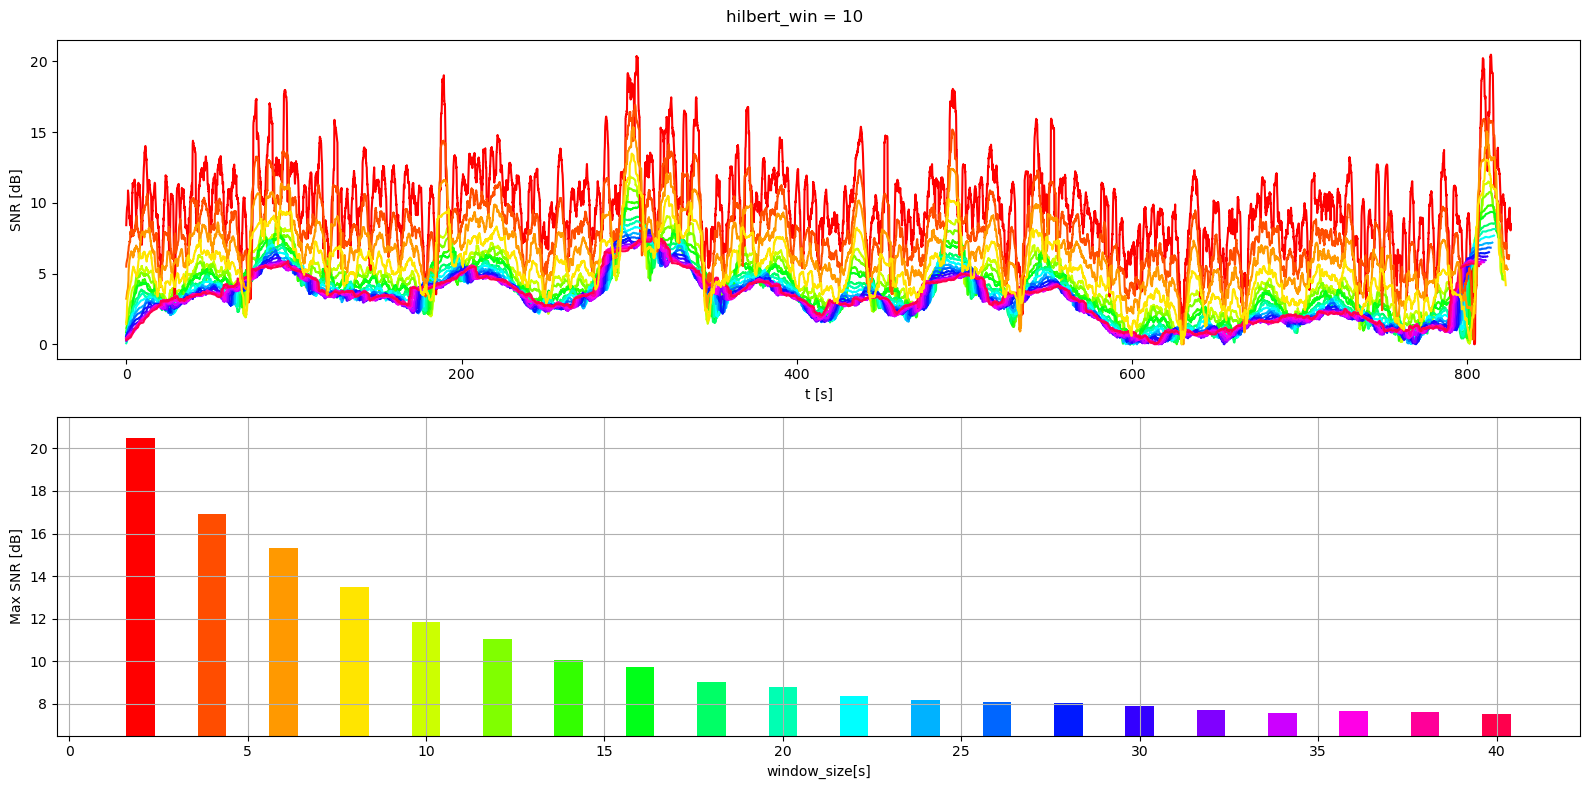

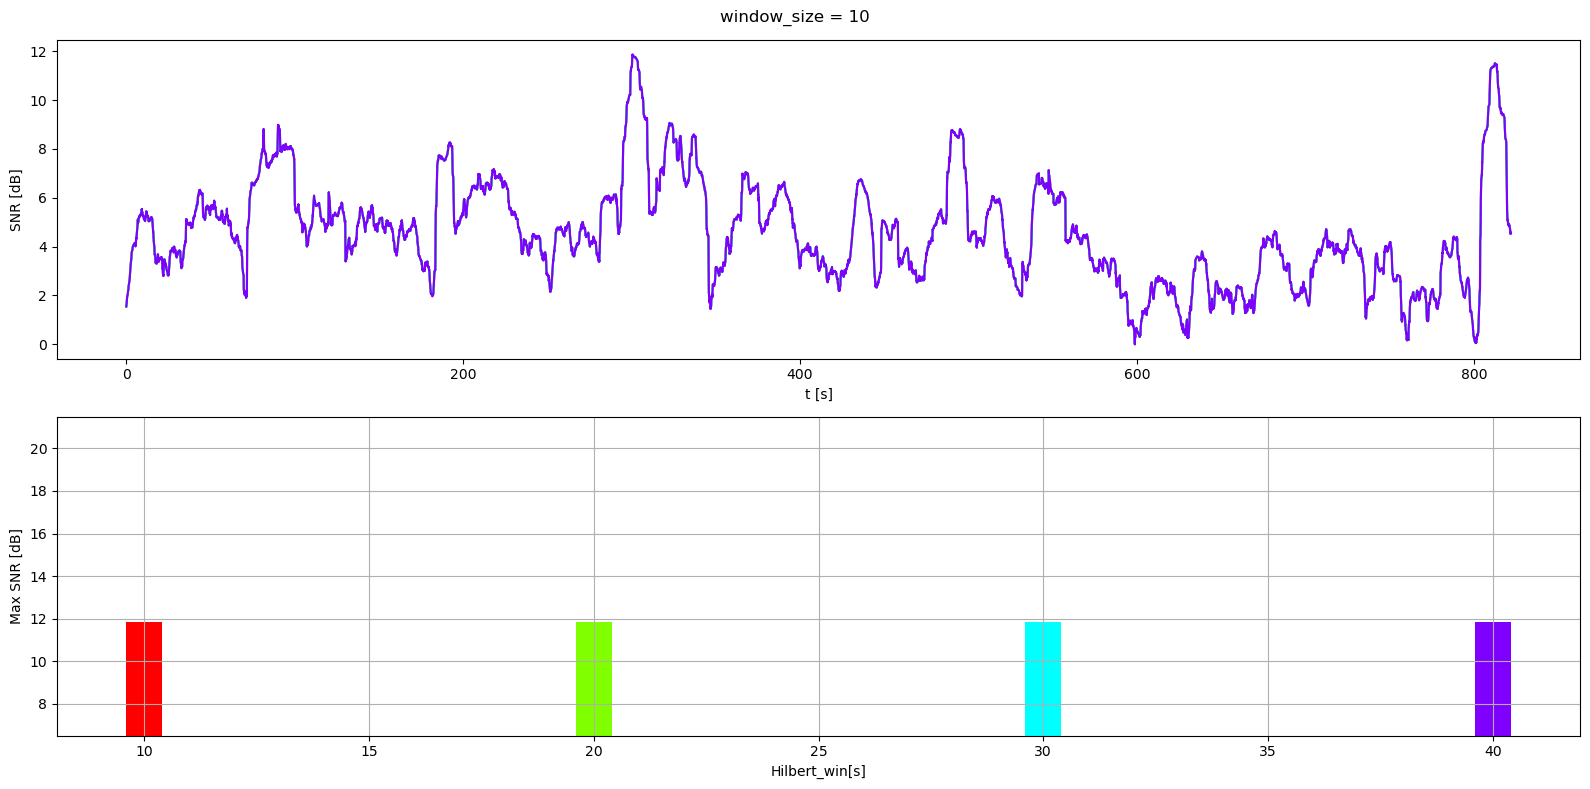

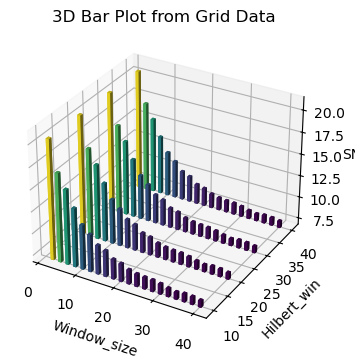


------------------------------
Best SNR     : 20.469907
window_size  : 2
hilbert_win  : 30
--------------------------------
Second Best SNR : 20.468221
window_size     : 2
hilbert_win     : 40
--------------------------------


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

fs = 10_000
#BB plot data
#Read vsc file
chunks = pd.read_csv("broadband_plot_list.csv", chunksize=1_000_000, usecols=["t", "BB", "plot_id"])
db = pd.concat(chunk for chunk in chunks)

db["plot_id"] = db["plot_id"].astype("category")
db["t"] = pd.to_numeric(db["t"], downcast="float")
db["BB"] = pd.to_numeric(db["BB"], downcast="float")

grouped = db.groupby("plot_id")

#Max SNR data
# Les inn hele CSV-filen
df = pd.read_csv("broadband_max_snr_matrix.csv", header=None)

# Fjern første rad og første kolonne
df_cleaned = df.iloc[1:, 1:]

# Konverter til NumPy-array
Max_SNR = df_cleaned.to_numpy(dtype=float)


num_window_iterations = len(Max_SNR[0])
num_hilbert_iterations = len(Max_SNR)
window_size = int(str(df[1][0]).split("_")[1])
hilbert_win = int(str(df[0][1]).split("_")[1])

bar_window_ax = np.linspace(window_size, window_size * num_window_iterations, num_window_iterations)
bar_hilb_ax = np.linspace(hilbert_win, hilbert_win * num_hilbert_iterations, num_hilbert_iterations)


window_colors = generate_vivid_colors(num_window_iterations)
hilbert_colors = generate_vivid_colors(num_hilbert_iterations)

##############################################################################################################################################################################
window_plot = plt.figure(figsize=(16,8))
hilbert_win_idx = 0
plt.subplot(2,1,1)
window_plot.suptitle(f"hilbert_win = {(hilbert_win_idx+1)*hilbert_win}")
for plot_id, group in grouped:
    plot_id_str = plot_id.split("/")
    win_id = plot_id_str[0].split("_")[1]
    hilb_id = plot_id_str[1].split("_")[1]
    
    if hilb_id == str((hilbert_win_idx+1)*hilbert_win):
        plt.plot(group["t"], group["BB"], label=f"Plot {plot_id}", color = window_colors[int(int(win_id)/window_size)-1])

plt.xlabel("t [s]")
plt.ylabel("SNR [dB]")


plt.subplot(2,1,2)
plt.bar(bar_window_ax,Max_SNR[hilbert_win_idx],color=window_colors)
plt.xlabel("window_size[s]")
plt.ylabel("Max SNR [dB]")
plt.ylim((np.min(Max_SNR)-1,np.max(Max_SNR)+1))
plt.grid()
plt.tight_layout()

##############################################################################################################################################################################
hilbert_plot = plt.figure(figsize=(16,8))
window_size_idx = 4

plt.subplot(2,1,1)
hilbert_plot.suptitle(f"window_size = {(window_size_idx+1)*window_size}")
for plot_id, group in grouped:
    plot_id_str = plot_id.split("/")
    win_id = plot_id_str[0].split("_")[1]
    hilb_id = plot_id_str[1].split("_")[1]
    
    if win_id == str((window_size_idx+1)*window_size):
        plt.plot(group["t"], group["BB"], label=f"Plot {plot_id}", color = hilbert_colors[int(int(hilb_id)/hilbert_win)-1])

plt.xlabel("t [s]")
plt.ylabel("SNR [dB]")

plt.subplot(2,1,2)
plt.bar(bar_hilb_ax,Max_SNR.T[window_size_idx],color=hilbert_colors)
plt.xlabel("Hilbert_win[s]")
plt.ylabel("Max SNR [dB]")
plt.ylim((np.min(Max_SNR)-1,np.max(Max_SNR)+1))
plt.grid()
plt.tight_layout()


##############################################################################################################################################################################
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm



# Make a meshgrid of x/y positions
x_pos, y_pos = np.meshgrid(bar_window_ax, bar_hilb_ax, indexing='xy')



# Flatten the grid for bar3d
x_pos = x_pos.ravel()
y_pos = y_pos.ravel()

dz = Max_SNR.ravel()                      # Heights of bars
zlim_min = dz.min()*0.9
zlim_max = np.max(Max_SNR)*1.05
dz_scaled = dz - zlim_min
z_pos = np.full_like(x_pos, zlim_min)        # Bars start at z = zlim_min

# Bar size
dx = dy = 0.8

# Normalize dz to 0–1 for colormap
norm_dz = (dz - dz.min()) / (dz.max() - dz.min())
# Color (optional: based on height)
colors3d = cm.viridis(norm_dz)

# Plot
fig3d = plt.figure(figsize=(16,4))
ax = fig3d.add_subplot(111, projection='3d')

ax.bar3d(x_pos-dx/2, y_pos-dy/2, z_pos, dx, dy, dz_scaled, color=colors3d, shade=True)

ax.set_xlabel('Window_size')
ax.set_ylabel('Hilbert_win')
ax.set_zlabel('SNR')
ax.set_title('3D Bar Plot from Grid Data')
ax.set_zlim(zlim_min,zlim_max)

#ax.set_xticks(np.unique(x_pos))
#ax.set_yticks(np.unique(y_pos))

plt.show()
##############################################################################################################################################################################

# Finn beste SNR
best_index = np.unravel_index(np.argmax(Max_SNR), Max_SNR.shape)
best_snr = Max_SNR[best_index]

# Midlertidig sett beste verdi til noe veldig lavt for å finne neste beste
Max_SNR_temp = Max_SNR.copy()
Max_SNR_temp[best_index] = -np.inf

second_index = np.unravel_index(np.argmax(Max_SNR_temp), Max_SNR.shape)
second_best_snr = Max_SNR[second_index]

# Print resultater
print("\n------------------------------")
print(f"Best SNR     : {best_snr:.6f}")
print(f"window_size  : {(best_index[1]+1) * window_size}")
print(f"hilbert_win  : {(best_index[0]+1) * hilbert_win}")
print("--------------------------------")
print(f"Second Best SNR : {second_best_snr:.6f}")
print(f"window_size     : {(second_index[1]+1) * window_size}")
print(f"hilbert_win     : {(second_index[0]+1) * hilbert_win}")
print("--------------------------------")
